# SHAP Tutorial 
<br>
Course sections:
<ol>
<li> Standard SHAP values
<li> SHAP aggregations
<li> Custom SHAP plots
<li> SHAP interaction values
<li> SHAP for categorical features
</ol>
<br>
<b>Dataset:</b> https://archive.ics.uci.edu/ml/datasets/Abalone

In [1]:
#imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

import shap
shap.initjs()

/Users/conorosully/miniconda3/envs/SHAP/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [2]:
#import dataset
data = pd.read_csv("../data/abalone.data",
                  names=["sex","length","diameter","height",
                         "whole weight","shucked weight",
                         "viscera weight","shell weight",
                         "rings"])

print(len(data))
data.head()

4177


,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Text(0.5, 0, 'whole weight')

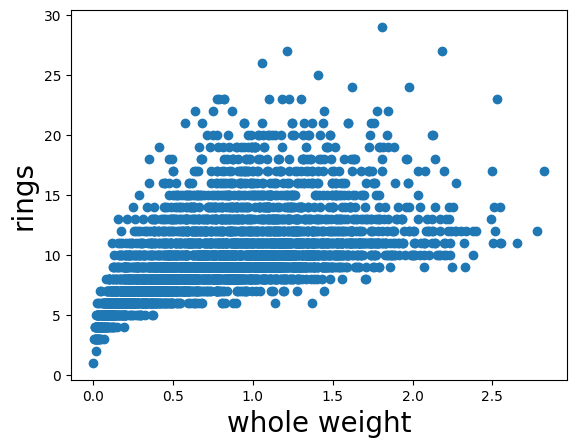

In [3]:
#Plot 1: whole weight
plt.scatter(data['whole weight'],data['rings'])
plt.ylabel('rings',size=20)
plt.xlabel('whole weight',size=20)

Text(0.5, 0, 'sex')

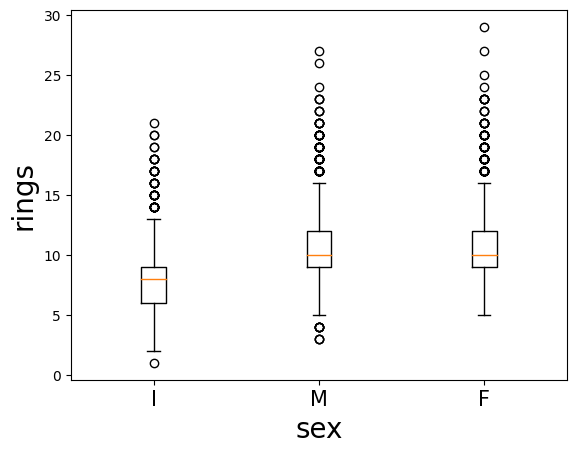

In [4]:
#Plot 2: sex
plt.boxplot(data[data.sex=='I']['rings'],positions=[1])
plt.boxplot(data[data.sex=='M']['rings'],positions=[2])
plt.boxplot(data[data.sex=='F']['rings'],positions=[3]) 

plt.xticks(ticks=[1,2,3],labels=['I', 'M', 'F'],size= 15)
plt.ylabel('rings',size=20)
plt.xlabel('sex',size=20)

<AxesSubplot:>

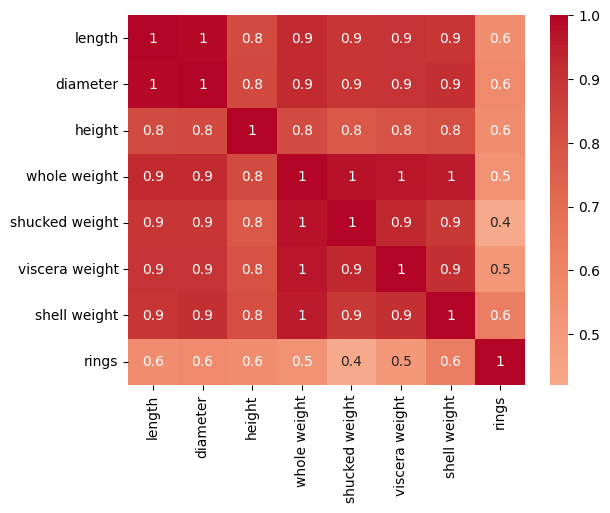

In [5]:
#Plot 3: Correlation heatmap
cont = ["length","diameter","height",
        "whole weight","shucked weight",
        "viscera weight","shell weight",
        "rings"]
corr_matrix = pd.DataFrame(data[cont],columns=cont).corr()

sns.heatmap(corr_matrix,
            cmap='coolwarm',
            center = 0,
            annot=True,
            fmt='.1g')

# Feature Engineering

In [6]:
y = data['rings']
X = data[["sex","length","height",
          "shucked weight","viscera weight","shell weight"]]

In [7]:
#Create dummy variables
X['sex.M'] = [1 if s == 'M' else 0 for s in X['sex']]
X['sex.F'] = [1 if s == 'F' else 0 for s in X['sex']]
X['sex.I'] = [1 if s == 'I' else 0 for s in X['sex']]
X = X.drop('sex', axis=1)

X.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,length,height,shucked weight,viscera weight,shell weight,sex.M,sex.F,sex.I
0,0.455,0.095,0.2245,0.1010,0.150,1,0,0
1,0.350,0.090,0.0995,0.0485,0.070,1,0,0
2,0.530,0.135,0.2565,0.1415,0.210,0,1,0
3,0.440,0.125,0.2155,0.1140,0.155,1,0,0
4,0.330,0.080,0.0895,0.0395,0.055,0,0,1


# Modelling

In [8]:
#Train model
model = xgb.XGBRegressor(objective="reg:squarederror") 
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Text(0.5, 0, 'Actual')

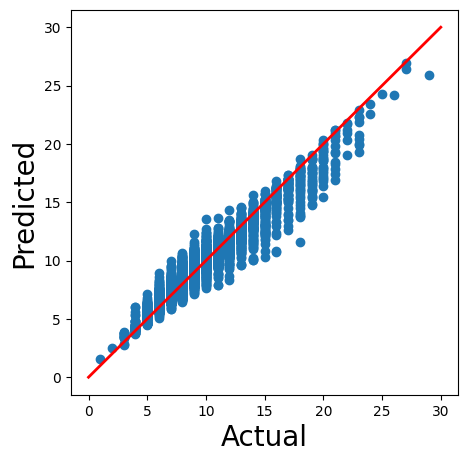

In [9]:
#Get predictions
y_pred = model.predict(X)

#Model evaluation
plt.figure(figsize=(5, 5))

plt.scatter(y,y_pred)
plt.plot([0, 30], 
         [0, 30], 
         color='r', 
         linestyle='-', 
         linewidth=2)

plt.ylabel('Predicted',size=20)
plt.xlabel('Actual',size=20)

# 1) Standard SHAP values

In [10]:
#Get shap values
explainer = shap.Explainer(model)
shap_values = explainer(X)

#shap_values = explainer(X[0:100])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


## Waterfall plot

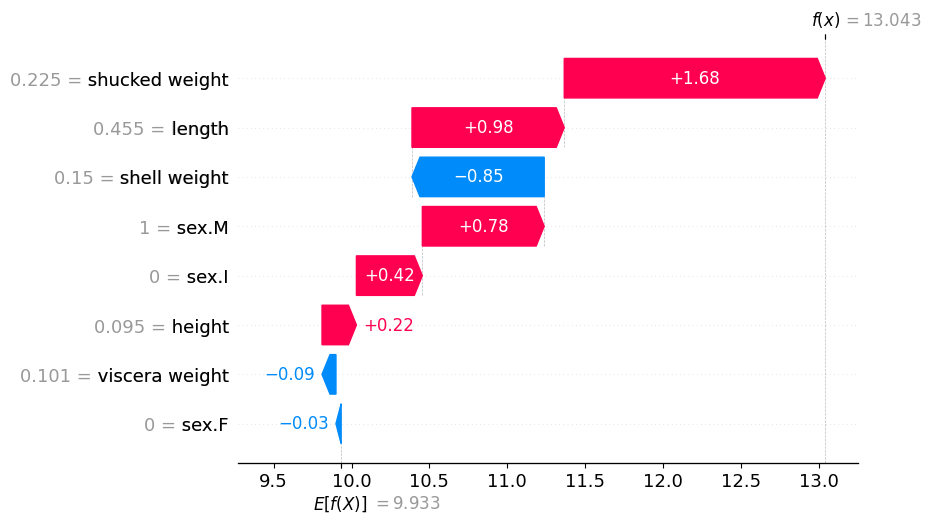

In [11]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

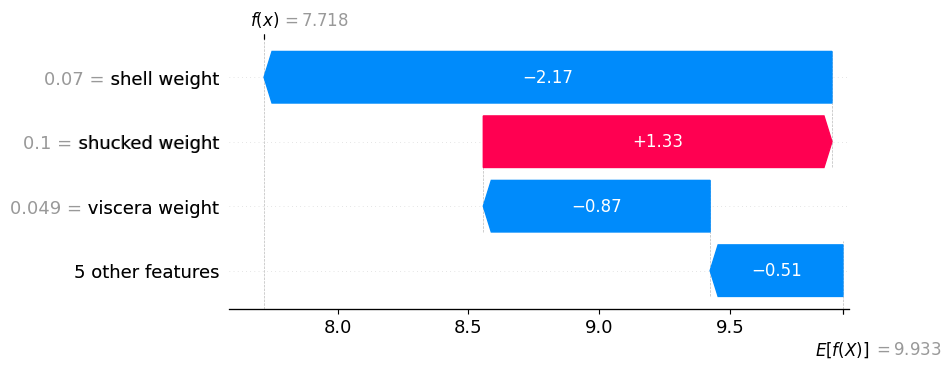

In [12]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values[1], max_display=4)

## SHAP for binary target variables 

In [13]:
#Binary target varibale
y_bin = [1 if y_>10 else 0 for y_ in y]

#Train model 
model_bin = xgb.XGBClassifier(objective="binary:logistic")
model_bin.fit(X, y_bin)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

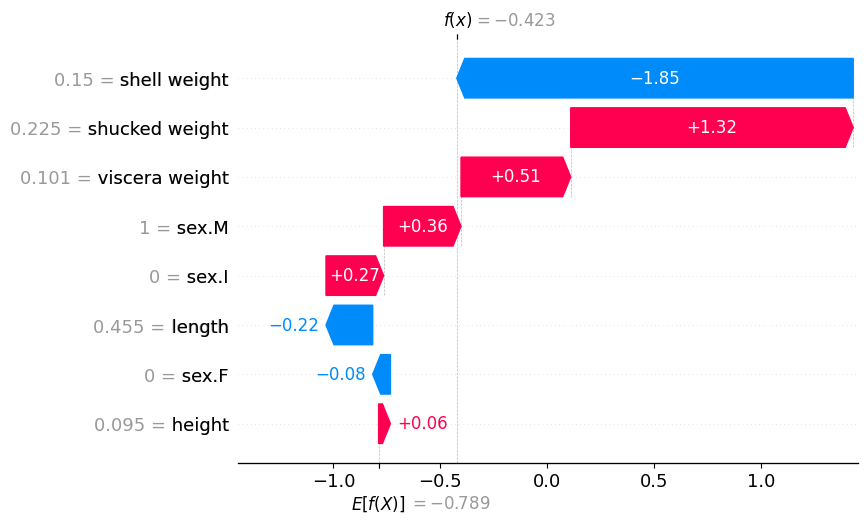

In [14]:
#Get shap values
explainer = shap.Explainer(model_bin)
shap_values_bin = explainer(X)

# waterfall plot for first observation
shap.plots.waterfall(shap_values_bin[0])

# 2) SHAP aggregations

<b>Note:</b> from here on we only consider the continous target variable 

## Force plot

In [16]:
shap.plots.force(shap_values[0])

## Stacked force plot

In [17]:
shap.plots.force(shap_values[0:100])

## Absolute Mean SHAP

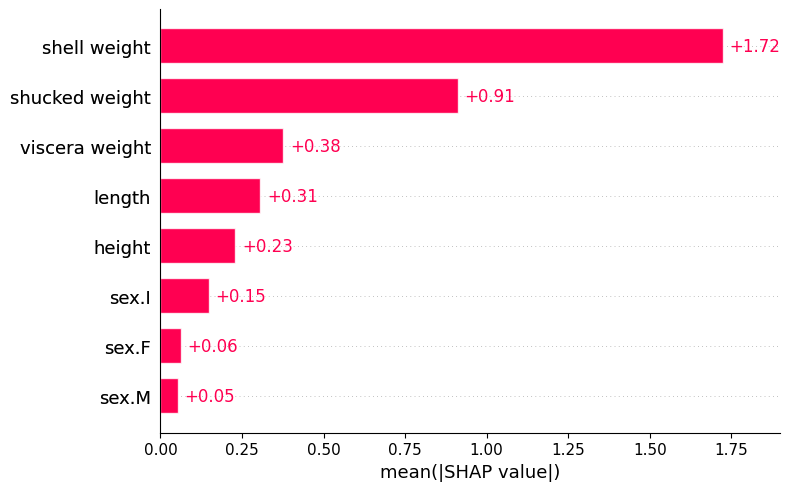

In [18]:
shap.plots.bar(shap_values)

## Beeswarm plot

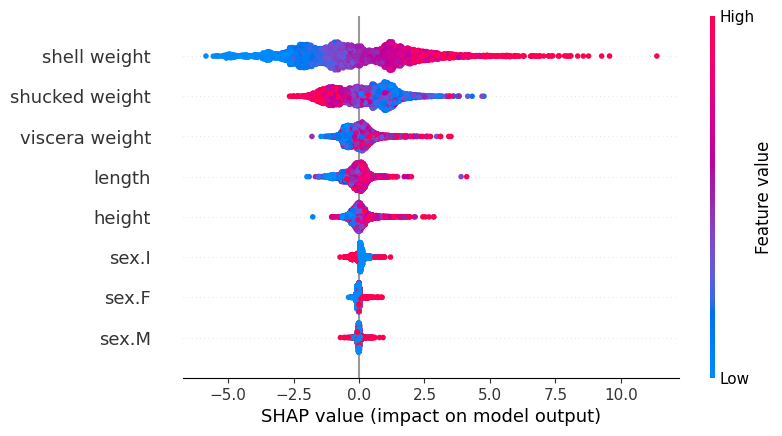

In [19]:
shap.plots.beeswarm(shap_values)

## Dependence plots

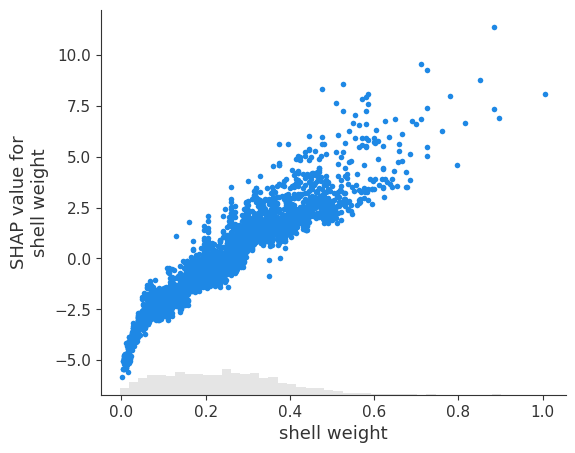

In [20]:
#Plot 1: shell weight
shap.plots.scatter(shap_values[:,"shell weight"])

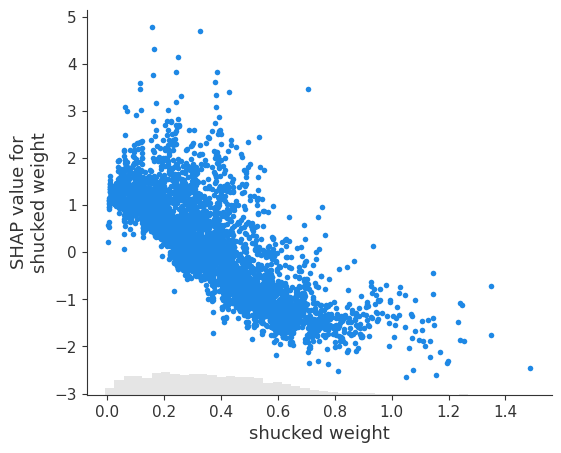

In [21]:
#Plot 2: shucked weight
shap.plots.scatter(shap_values[:,"shucked weight"])

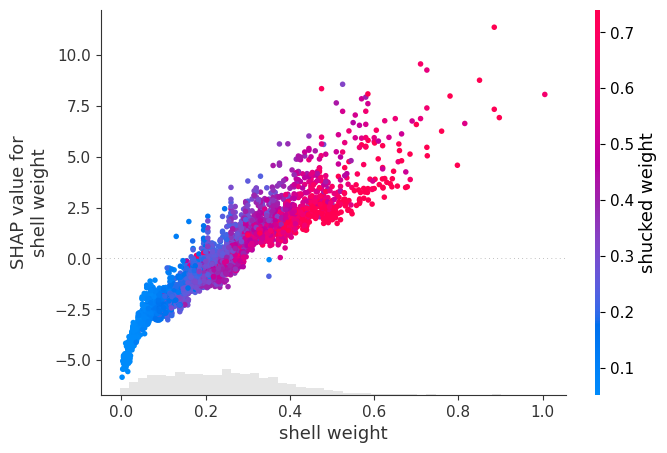

In [22]:
shap.plots.scatter(shap_values[:,"shell weight"],
                   color=shap_values[:,"shucked weight"])

# 3) Custom Plots

In [23]:
#Output SHAP object 
shap_values

.values =
array([[ 9.78181422e-01,  2.21020222e-01,  1.67678404e+00, ...,
         7.82850564e-01, -3.30441929e-02,  4.23465639e-01],
       [-7.52807617e-01, -1.23237863e-01,  1.33367944e+00, ...,
        -5.40658832e-02, -7.04995170e-02,  4.92611408e-01],
       [-3.30464244e-01,  6.57544360e-02,  4.97811854e-01, ...,
         5.79431430e-02,  1.66278422e-01,  2.86125392e-01],
       ...,
       [ 1.76525339e-01,  1.70586139e-01, -1.09874797e+00, ...,
        -1.24536781e-03,  1.44324331e-02,  5.35513014e-02],
       [ 1.07000619e-01,  2.22403854e-01, -9.88345206e-01, ...,
         2.23717615e-02,  1.47957215e-02,  7.15174899e-02],
       [-8.65472630e-02,  1.72838926e-01, -9.09051359e-01, ...,
        -7.06533110e-03,  1.45645300e-02,  1.14922017e-01]], dtype=float32)

.base_values =
array([9.932759, 9.932759, 9.932759, ..., 9.932759, 9.932759, 9.932759],
      dtype=float32)

.data =
array([[0.455 , 0.095 , 0.2245, ..., 1.    , 0.    , 0.    ],
       [0.35  , 0.09  , 0.0995, ..., 

In [24]:
np.shape(shap_values.values)

(4177, 8)

<AxesSubplot:>

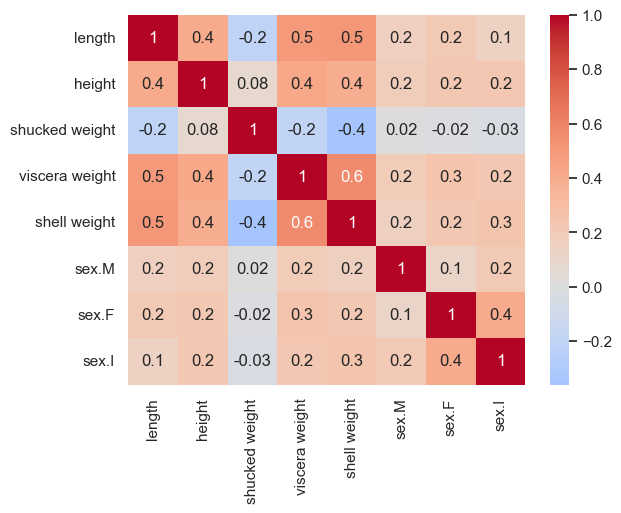

In [25]:
# SHAP correlation plot 
corr_matrix = pd.DataFrame(shap_values.values,
                           columns=X.columns).corr()

sns.set(font_scale=1)
sns.heatmap(corr_matrix,
            cmap='coolwarm',
            center = 0, 
            annot=True,
            fmt='.1g')

# 4) SHAP interaction value

In [26]:
#Get SHAP interaction values
explainer = shap.Explainer(model)
shap_interaction = explainer.shap_interaction_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [27]:
#Get shape of interaction values
np.shape(shap_interaction)

(4177, 8, 8)

In [28]:
# SHAP interaction values for first employee
shap_0 = np.round(shap_interaction[0],2)
pd.DataFrame(shap_0,
             index=X.columns,
             columns=X.columns)

,length,height,shucked weight,viscera weight,shell weight,sex.M,sex.F,sex.I
length,-0.30,0.44,0.10,-0.18,0.59,0.27,0.04,0.02
height,0.44,-0.26,0.01,-0.09,-0.02,0.16,-0.01,-0.01
shucked weight,0.10,0.01,1.21,0.00,-0.16,0.45,-0.05,0.11
viscera weight,-0.18,-0.09,0.00,-0.20,0.28,0.06,-0.00,0.03
shell weight,0.59,-0.02,-0.16,0.28,-1.87,0.14,0.06,0.14
sex.M,0.27,0.16,0.45,0.06,0.14,-0.30,0.00,0.00
sex.F,0.04,-0.01,-0.05,-0.00,0.06,0.00,-0.07,0.00
sex.I,0.02,-0.01,0.11,0.03,0.14,0.00,0.00,0.13


## Mean SHAP interaction values

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0, 0.5, 'length'),
  Text(0, 1.5, 'height'),
  Text(0, 2.5, 'shucked weight'),
  Text(0, 3.5, 'viscera weight'),
  Text(0, 4.5, 'shell weight'),
  Text(0, 5.5, 'sex.M'),
  Text(0, 6.5, 'sex.F'),
  Text(0, 7.5, 'sex.I')])

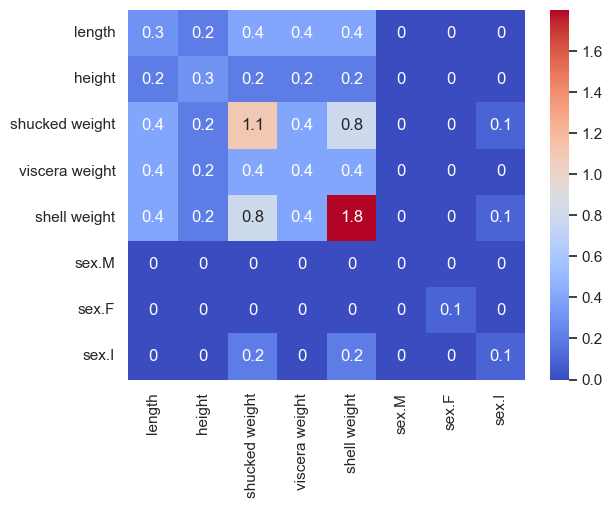

In [29]:
# Get absolute mean of matrices
mean_shap = np.abs(shap_interaction).mean(0)
mean_shap = np.round(mean_shap,1)

df = pd.DataFrame(mean_shap,index=X.columns,columns=X.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2,inplace=True)

# display 
sns.set(font_scale=1)
sns.heatmap(df,cmap='coolwarm',annot=True)
plt.yticks(rotation=0) 

## Dependence plot

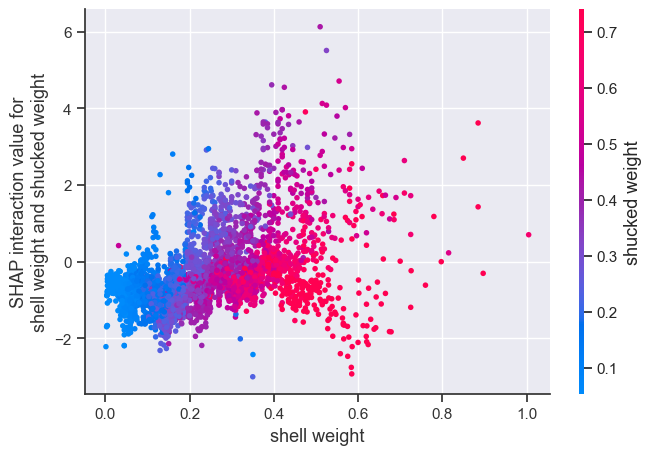

In [30]:
shap.dependence_plot(
    ("shell weight", "shucked weight"),
    shap_interaction, X,
    display_features=X)

Text(0, 0.5, 'shell weight')

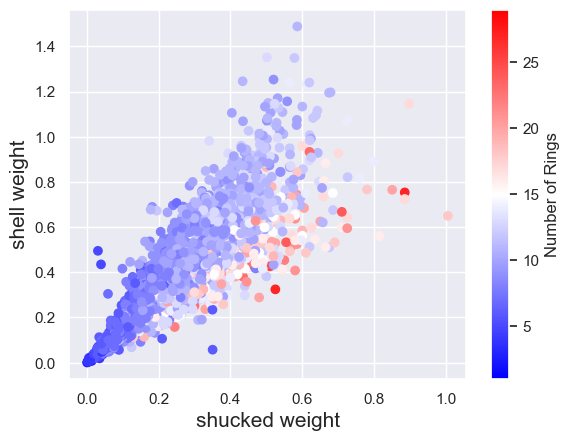

In [31]:
#Interaction between shell weight and shucked weight
plt.scatter(data["shell weight"],
            data["shucked weight"],
            c=data["rings"],
            cmap='bwr')
plt.colorbar(label="Number of Rings", 
             orientation="vertical")

plt.xlabel('shucked weight',size=15)
plt.ylabel('shell weight',size=15)

# 5) SHAP for categorical variables

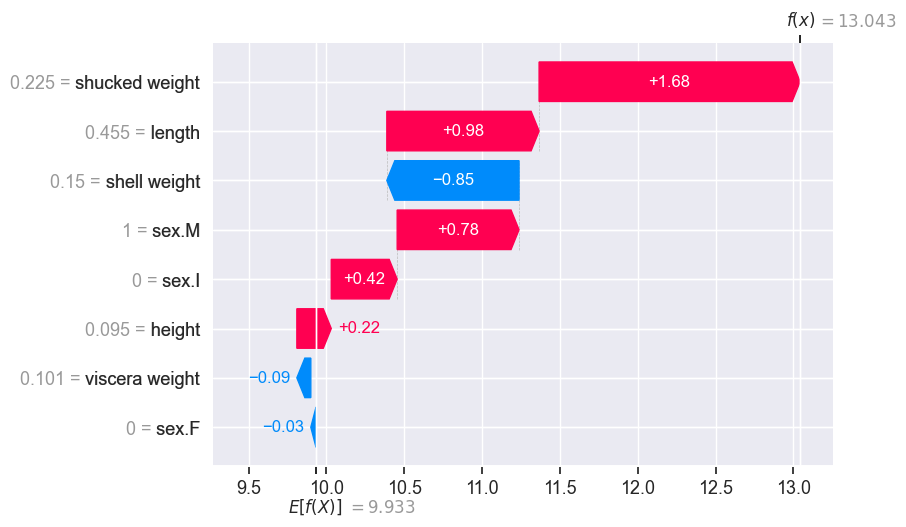

In [32]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

In [34]:
# SHAP values are in same order as features
X.columns

Index(['length', 'height', 'shucked weight', 'viscera weight', 'shell weight',
       'sex.M', 'sex.F', 'sex.I'],
      dtype='object')

In [35]:
new_shap_values = []

#loop over all shap values:
for values in shap_values.values:
    
    #sum SHAP values for sex 
    sv = list(values)
    sv = sv[0:5] + [sum(sv[5:8])]
    
    new_shap_values.append(sv)

In [36]:
#replace shap values
shap_values.values = np.array(new_shap_values)

#replace data with categorical feature values 
X_cat = data[["length","height",
              "shucked weight","viscera weight",
              "shell weight","sex"]]
shap_values.data = np.array(X_cat)

#update feature names
shap_values.feature_names = list(X_cat.columns)

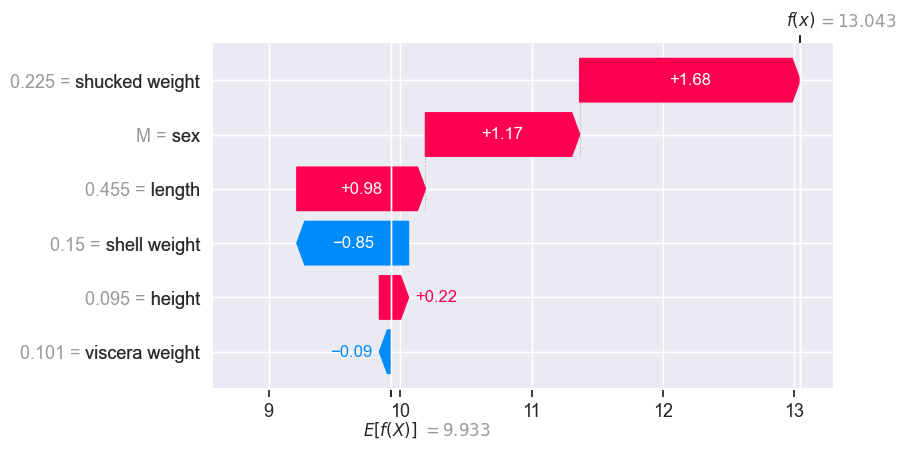

In [37]:
shap.plots.waterfall(shap_values[0])

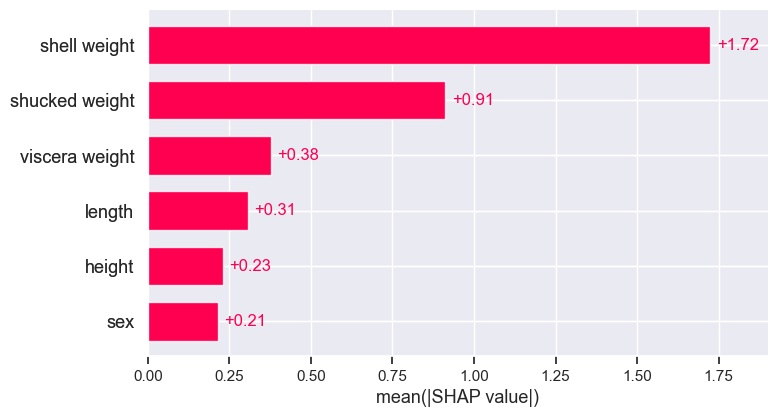

In [38]:
shap.plots.bar(shap_values)

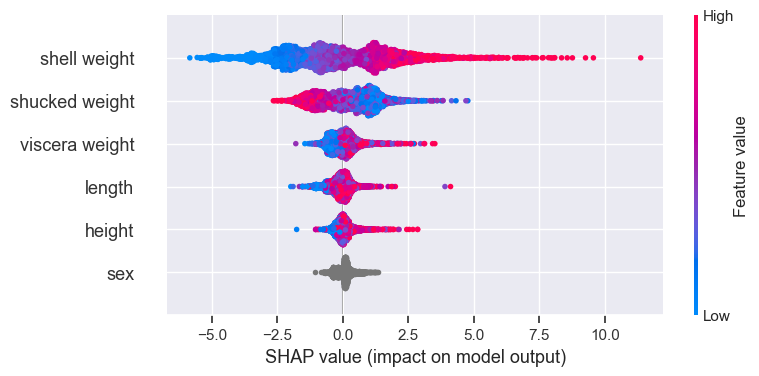

In [39]:
shap.plots.beeswarm(shap_values)

Text(0.5, 0, 'Sex')

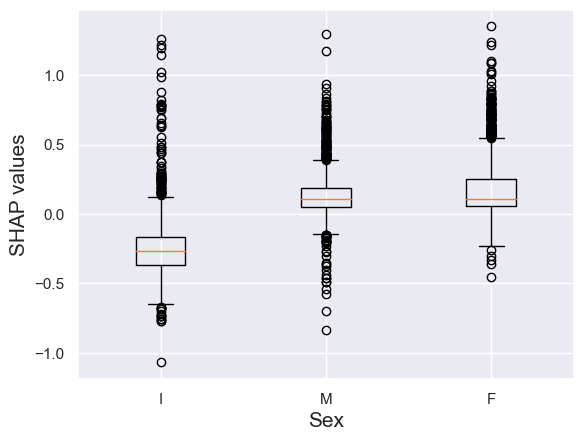

In [40]:
#get shaply values and data
sex_values = shap_values[:,"sex"].values
sex_data = shap_values[:,"sex"].data
sex_categories = ['I','M','F']

#split sex shap values based on category
sex_groups = []
for s in sex_categories:
    relevant_values = sex_values[sex_data == s]
    sex_groups.append(relevant_values)
    

#plot boxplot
plt.boxplot(sex_groups,labels=sex_categories)

plt.ylabel('SHAP values',size=15)
plt.xlabel('Sex',size=15)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


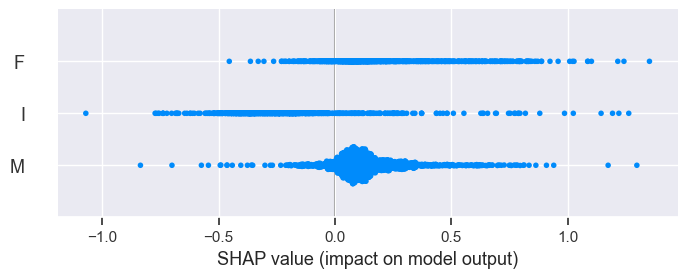

In [41]:
#Create for placeholder SHAP values
shap_values_sex = explainer(X)

#get shaply values and data
sex_values = shap_values[:,"sex"].values
sex_data = shap_values[:,"sex"].data
sex_categories = ['I','M','F']

#Create new SHAP values array

#Split odor SHAP values by unique odor categories
new_shap_values = [np.array(pd.Series(sex_values)[sex_data==s]) 
                    for s in sex_categories]

#Each sublist needs to be the same length
max_len = max([len(v) for v in new_shap_values])
new_shap_values = [np.append(vs,[np.nan]*(max_len - len(vs))) for vs in new_shap_values]
new_shap_values = np.array(new_shap_values)

#transpost matrix so categories are columns and SHAP values are rows
new_shap_values = new_shap_values.transpose()

#replace shap values
shap_values_sex.values = np.array(new_shap_values)

#replace data with placeholder array
shap_values_sex.data = np.array([[0]*len(sex_categories)]*max_len)

#replace base data with placeholder array
shap_values_sex.base = np.array([0]*max_len)

#replace feature names with category labels
shap_values_sex.feature_names = list(sex_categories)

#Use beeswarm as before
shap.plots.beeswarm(shap_values_sex,color_bar=False)